# Plot data from VIEWS storage, both levels

In [1]:
import requests
import pandas as pd
import json
import os
from pathlib import Path

#import matplotlib.pyplot as plt

# External
import geopandas as gpd
import sqlalchemy as sa

# VIEWS
from viewser.operations import fetch
from views_mapper2.mapper2 import *
from views_mapper2.BBoxWriter import *
from views_mapper2.dictionary_writer import *
from ingester3.config import source_db_path
from views_forecasts.extensions import *


## Select forecasts to fetch

In [5]:
EndOfHistory = 540

import pandas as pd

# Expects the parquet file to be in the same directory
cm_predictions = pd.read_parquet('predictions_forecasting_20250219_094356.parquet', engine='pyarrow')

# Rename to work with remaining code
cm_predictions.rename(columns={'pred_ln_ged_sb_dep':'main_mean_ln'}, inplace=True)

cm_predictions = cm_predictions.reset_index()
cm_predictions


,month_id,country_id,main_mean_ln
0,541,1,0.003721
1,541,2,0.003580
2,541,3,0.006463
3,541,4,0.021813
4,541,5,0.003580
...,...,...,...
6871,576,242,0.125066
6872,576,243,0.093200
6873,576,244,0.146961
6874,576,245,3.780322


In [6]:
# Expects the parquet file to be in the same directory
pgm_predictions = pd.read_parquet('predictions_forecasting_20250219_164059.parquet', engine='pyarrow')

pgm_predictions = pgm_predictions.reset_index()

# Rename to work with remaining code
pgm_predictions.rename(columns={'pred_ln_ged_sb_dep':'main_mean_ln'}, inplace=True)

pgm_predictions

,month_id,priogrid_id,main_mean_ln
0,541,62356,0.000192
1,541,79599,0.000088
2,541,79600,0.000133
3,541,79601,0.000103
4,541,80317,0.000175
...,...,...,...
471955,576,190496,-0.000563
471956,576,190507,-0.000950
471957,576,190508,-0.000739
471958,576,190510,-0.000975


## Set prediction step (month) to analyze

In [7]:
step = 3 # set step to plot

In [8]:
# Generate month to plot based on first month of selected dataset and the step chosen above

t = (pgm_predictions['month_id'].min())-1
month_to_plot = t + step 
month_to_plot

543

## Set output folder

In [9]:
import os
home = os.path.expanduser("~")
#dropbox = home+'/ViEWS Dropbox/VIEWS research collaboration/Dissemination/Working Papers/Prediction Competition Preprint Maps/'
desktop = home+'/Desktop/' # (Toggle on to save to desktop) Change to your directory
#forecasts.to_csv(desktop+'forecasts.csv', index=False)

## Fetch geometries for plotting and merge with dataframe

In [10]:
# Get priogrid geometries
engine = sa.create_engine(source_db_path)
gdf_pgm_master = gpd.GeoDataFrame.from_postgis(
    "SELECT id as pg_id, in_africa, in_me, geom FROM prod.priogrid", 
    engine, 
    geom_col='geom'
)
gdf_pgm_master = gdf_pgm_master.to_crs(4326)
gdf_pgm = gdf_pgm_master.copy()

gdf_pgm.rename(columns = {'pg_id':'priogrid_id'}, inplace = True)
gdf_pgm


,priogrid_id,in_africa,in_me,geom
0,240318,False,False,"POLYGON ((98.50000 76.50000, 98.50000 77.00000..."
1,173423,False,False,"POLYGON ((131.00000 30.00000, 131.00000 30.500..."
2,234640,False,False,"POLYGON ((139.50000 72.50000, 139.50000 73.000..."
3,211904,False,False,"POLYGON ((-68.50000 57.00000, -68.50000 57.500..."
4,218313,False,False,"POLYGON ((-104.00000 61.50000, -104.00000 62.0..."
...,...,...,...,...
64813,169611,True,True,"POLYGON ((25.00000 27.50000, 25.00000 28.00000..."
64814,153089,False,True,"POLYGON ((44.00000 16.00000, 44.00000 16.50000..."
64815,172514,False,True,"POLYGON ((36.50000 29.50000, 36.50000 30.00000..."
64816,170344,True,True,"POLYGON ((31.50000 28.00000, 31.50000 28.50000..."


In [11]:

# Get country geometries to overlay as borders
engine = sa.create_engine(source_db_path) 
gdf_cm_master = gpd.GeoDataFrame.from_postgis(
    "SELECT id as country_id, name, in_africa, in_me, geom FROM prod.country",
    engine,
    geom_col='geom'
)
gdf_cm_master = gdf_cm_master.to_crs(4326)
gdf_cm = gdf_cm_master.copy()


In [12]:
# Can be skipped if there are no cm predictions

cm_data = pd.merge(cm_predictions, gdf_cm, on="country_id", how="left")
gdf_cm = gpd.GeoDataFrame(cm_data, geometry="geom")

gdf_cm


,month_id,country_id,main_mean_ln,name,in_africa,in_me,geom
0,541,1,0.003721,Guyana,0,0,"MULTIPOLYGON (((-58.17262 6.81222, -58.15494 6..."
1,541,2,0.003580,Suriname,0,0,"MULTIPOLYGON (((-55.12796 5.82217, -55.10445 5..."
2,541,3,0.006463,Trinidad and Tobago,0,0,"MULTIPOLYGON (((-61.07945 10.82416, -61.07556 ..."
3,541,4,0.021813,Venezuela,0,0,"MULTIPOLYGON (((-66.31029 10.62602, -66.28309 ..."
4,541,5,0.003580,Samoa,0,0,"MULTIPOLYGON (((-172.59650 -13.50911, -172.551..."
...,...,...,...,...,...,...,...
6871,576,242,0.125066,Tanzania,1,0,"MULTIPOLYGON (((34.13636 -9.57117, 34.07444 -9..."
6872,576,243,0.093200,Morocco,1,0,"MULTIPOLYGON (((-4.42042 35.15125, -4.35792 35..."
6873,576,244,0.146961,Mauritania,1,0,"MULTIPOLYGON (((-10.71639 15.43890, -10.71945 ..."
6874,576,245,3.780322,Sudan,1,0,"MULTIPOLYGON (((34.09223 9.47747, 33.90162 9.4..."


In [13]:
pgm_data = pd.merge(pgm_predictions, gdf_pgm, on="priogrid_id", how="left")
gdf_pgm = gpd.GeoDataFrame(pgm_data, geometry="geom")

gdf_pgm

,month_id,priogrid_id,main_mean_ln,in_africa,in_me,geom
0,541,62356,0.000192,True,False,"POLYGON ((37.50000 -47.00000, 37.50000 -46.500..."
1,541,79599,0.000088,True,False,"POLYGON ((19.00000 -35.00000, 19.00000 -34.500..."
2,541,79600,0.000133,True,False,"POLYGON ((19.50000 -35.00000, 19.50000 -34.500..."
3,541,79601,0.000103,True,False,"POLYGON ((20.00000 -35.00000, 20.00000 -34.500..."
4,541,80317,0.000175,True,False,"POLYGON ((18.00000 -34.50000, 18.00000 -34.000..."
...,...,...,...,...,...,...
471955,576,190496,-0.000563,False,True,"POLYGON ((27.50000 42.00000, 27.50000 42.50000..."
471956,576,190507,-0.000950,False,True,"POLYGON ((33.00000 42.00000, 33.00000 42.50000..."
471957,576,190508,-0.000739,False,True,"POLYGON ((33.50000 42.00000, 33.50000 42.50000..."
471958,576,190510,-0.000975,False,True,"POLYGON ((34.50000 42.00000, 34.50000 42.50000..."


## Plot settings

### Overwrite relevant Mapper2 functions for flexibility in settings

In [14]:
# Don't change

from views_mapper2.mapper2 import Mapper2

def custom_add_colorbar(
    self,
    cmap,
    vmin,
    vmax,
    location="right",
    size="5%",
    pad=0.1,
    transparency=None,
    labelsize=10,
    tickparams=None,
):
    norm = plt.Normalize(vmin, vmax)
    if isinstance(cmap, str):
        cmap = plt.get_cmap(cmap)
    cmap = color.force_alpha_colormap(cmap=cmap, alpha=transparency)
    scalar_to_rgba = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    divider = make_axes_locatable(self.ax)
    self.cax = divider.append_axes(location, size, pad)
    self.cax.tick_params(labelsize=labelsize)

    tickvalues = (
        list(tickparams.values()) if tickparams is not None else None
    )
    self.cbar = plt.colorbar(
        scalar_to_rgba, cax=self.cax, ticks=tickvalues
    )
    if tickparams is not None:
        self.cbar.set_ticklabels(list(tickparams.keys()))
    return self

# Monkey patch the method
Mapper2.add_colorbar = custom_add_colorbar




### Plot and save the data

rainbow map all done!


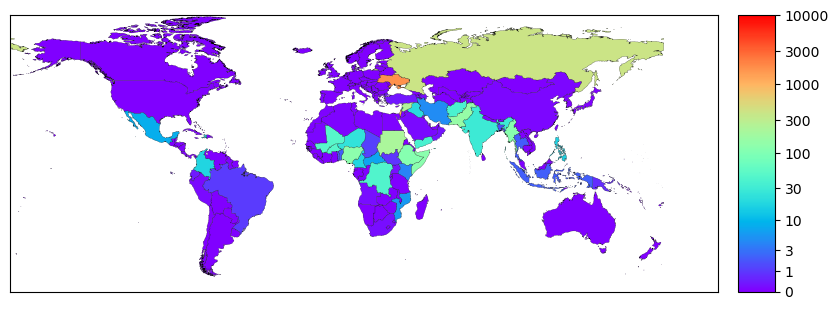

In [15]:
# CM

cm_data_to_plot = gdf_cm[gdf_cm['month_id'] == month_to_plot]  

region = 'globe' # options are 'ame', 'me' or 'globe'

cmap = ['rainbow']

for cmaps in cmap:
    test_map = Mapper2(
    width=10,   # dimension width
    height=10,  # dimension height
    frame_on=True,
    bbox=bbox_from_cid(f'{region}'), 
    ).add_layer(
    gdf=cm_data_to_plot,  
    cmap=cmaps,
    transparency=1,
    background=None, 
    map_dictionary=dictionary_stand_1p_10k, # changed based on column. Here prepped for single log scale, with 10k fatalities as max on the plot
    edgecolor="black",  # border color choice
    linewidth=0.15,  # line size choice
    column="main_mean_ln", # Single log data column
    )

# Print map status
print(f'{cmaps} map all done!')

# Save the map with appropriate filename
#test_map.save(f'{desktop}/map_newrun_cm_s{step}_for_m{month_to_plot}_ln1_{region}_{cmaps}', dpi=350)


In [16]:
# Create custom scale from 0-300 for the pgm plots, from Mapper2, for logged data

custom_scale = [0, 3, 10, 30, 100, 300]
custom_1p = log1p_dict(custom_scale)

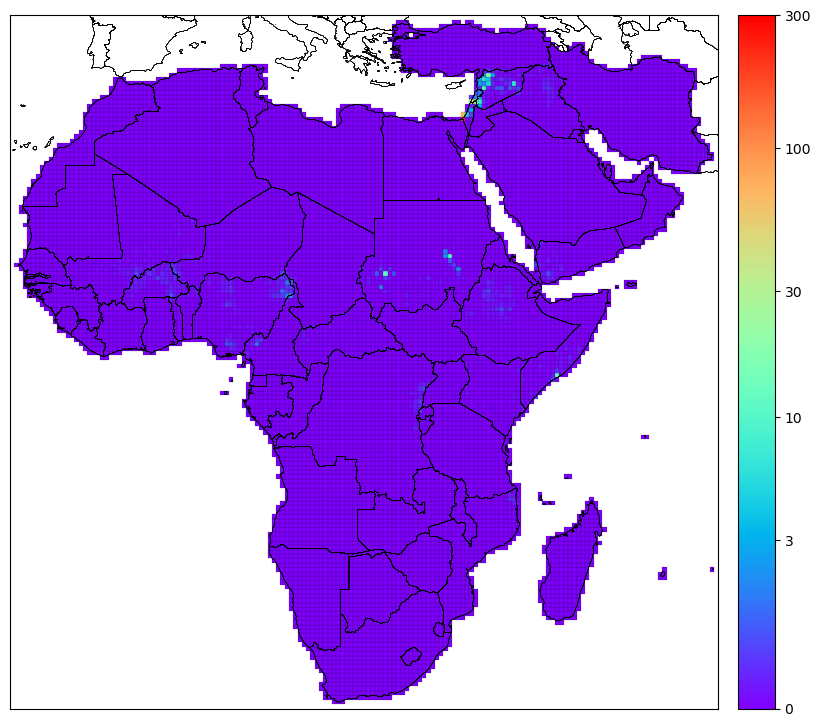

In [17]:
# PGM

pgm_data_to_plot = gdf_pgm[gdf_pgm['month_id'] == month_to_plot]  

region = 'ame' #options are 'ame', 'me' or 'globe'

cmap = ['rainbow']
#cmap = ['rainbow', 'binary']

for cmaps in cmap:
    test_map = Mapper2(
    width=10,   # dimension width
    height=10,  # dimension height
    frame_on=True,
    bbox=bbox_from_cid(f'{region}'), 
    ).add_layer(
    gdf=pgm_data_to_plot,  
    cmap=cmaps,
    transparency=1,
    background=None, 
    map_dictionary=custom_1p, # changed based on column
    edgecolor="black",  # border color choice
    linewidth=0.1,  # line size choice
    column="main_mean_ln", 
    )
    # Jim procedure for country border creation using the geometries inherent to views3
    ax = test_map.ax
    gdf_cm.plot(ax=ax, edgecolor='black', linewidth=0.05, facecolor='None')

    
# Save the map with appropriate filename
#
# test_map.save(f'{desktop}/map_newun_cm_s{step}_for_m{month_to_plot}_ln1_{region}_{cmaps}', dpi=350)

In [ ]:
print('All done!')